In [0]:
%run path_to_s3_notebook

ERROR: Invalid requirement: 'boto3/dev/null'
Hint: It looks like a path. File 'boto3/dev/null' does not exist.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Installation Successful


In [0]:
df.show(5)

+----------+-------+-------+----+-----+------+
|      date| county|  state|fips|cases|deaths|
+----------+-------+-------+----+-----+------+
|2021-01-01|Autauga|Alabama|1001| 4239|    50|
|2021-01-01|Baldwin|Alabama|1003|13823|   169|
|2021-01-01|Barbour|Alabama|1005| 1517|    33|
|2021-01-01|   Bibb|Alabama|1007| 1854|    46|
|2021-01-01| Blount|Alabama|1009| 4693|    63|
+----------+-------+-------+----+-----+------+
only showing top 5 rows



In [0]:
df.count()

3525161

In [0]:
from pyspark.sql.functions import col,min,max

In [0]:
from pyspark.sql.functions import col,min,max
df.agg(min("date"),max("date")).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2020-01-21|2023-03-23|
+----------+----------+



In [0]:
from pyspark.sql.functions import date_format,sum,round
import plotly.express  as px

In [0]:
df.\
  groupBy(date_format("date","yyyy").alias("year")).\
    agg(sum("deaths").alias("total_deaths")).\
      orderBy("year").\
        show(truncate=False)

+----+------------+
|year|total_deaths|
+----+------------+
|2020|46413785    |
|2021|223987036   |
|2022|367427258   |
|2023|91790485    |
+----+------------+



In [0]:
df.\
  groupBy(date_format("date","yyyy").alias("year")).\
    agg(round((sum("deaths")/1_000_000),2).alias("total_deaths_in_millions")).\
      orderBy("year").\
        show()

+----+------------------------+
|year|total_deaths_in_millions|
+----+------------------------+
|2020|                   46.41|
|2021|                  223.99|
|2022|                  367.43|
|2023|                   91.79|
+----+------------------------+



In [0]:
death_df = df.\
  groupBy(date_format("date","yyyy").alias("year")).\
    agg(round((sum("deaths")/1_000_000),2).alias("total_deaths_in_millions")).\
      orderBy("year")
  
death_pd = death_df.toPandas()

fig = px.bar(death_pd,x='year',y='total_deaths_in_millions',color='year',text_auto=True)
fig.show()

In [0]:
df_total_death = df.\
  groupBy(date_format("date","yyyy").alias("year"),"state").\
      agg(sum("deaths").alias("total_death"))

In [0]:
from pyspark.sql.window import Window
from pyspark.sql import functions as f

In [0]:
window_spec = Window.partitionBy("year").orderBy(col("total_death").desc())

In [0]:
df_total_death.\
  withColumn("ranks",f.row_number().over(window_spec)).\
    filter(col("ranks")==1).\
      orderBy("year","state","total_death").\
        show()

+----+----------+-----------+-----+
|year|     state|total_death|ranks|
+----+----------+-----------+-----+
|2020|  New York|    8320598|    1|
|2021|California|   22532428|    1|
|2022|California|   33481697|    1|
|2023|California|    8424694|    1|
+----+----------+-----------+-----+



In [0]:
df_state_pd = df_total_death.\
  withColumn("ranks",f.row_number().over(window_spec)).\
    filter(col("ranks")==1).\
      orderBy("year","state","total_death").\
        toPandas()

In [0]:
fig = px.pie(df_state_pd,values="total_death",names="year",hover_data=["state"])
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(uniformtext_minsize=6, uniformtext_mode='hide')
fig.show()

In [0]:
df_total_death = df.\
  groupBy(date_format("date","yyyy").alias("year"),"state").\
      agg(sum("cases").alias("total_cases"))

window_spec = Window.partitionBy("year").orderBy(col("total_cases").desc())

df_cases_pd = df_total_death.\
  withColumn("ranks",f.row_number().over(window_spec)).\
    filter(col("ranks")==1).\
      orderBy("year","state","total_cases").\
        toPandas()

fig = px.pie(df_cases_pd,values="total_cases",names="year",hover_data=["state"])
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(uniformtext_minsize=6, uniformtext_mode='hide')
fig.show()

In [0]:
df_total = df.\
  groupBy(date_format("date","yyyy").alias("year"),"state","county").\
      agg(sum("deaths").alias("total_deaths"),sum("cases").alias("total_cases"))

In [0]:
window_spec = Window.partitionBy("state","county").orderBy("year")

In [0]:
from pyspark.sql.functions import lag,round,when

In [0]:
lag_df = df_total.\
  withColumn("cases_lag",lag("total_cases").over(window_spec)).\
    withColumn("death_lag",lag("total_deaths").over(window_spec))

In [0]:
# lag_df.show(5)

In [0]:
# gr = ((curr - prev )/ prev) * 100
growth_df = lag_df.\
  withColumn("cases_growth",when(col("cases_lag").isNotNull(),
                                round((((col("total_cases")-col("cases_lag")) / col("cases_lag")) * 100),2)  
                                )
             ).\
                 withColumn("death_growth",when(col("death_lag").isNotNull(),
                                round((((col("total_deaths")-col("death_lag")) / col("death_lag")) * 100),2)  
                                )
             ).\
               select("year","state","county","cases_growth","death_growth").\
                 orderBy("state","county","year")


In [0]:
# growth_df.filter(col("state") == "Georgia").show()

In [0]:
pd_df = growth_df.toPandas()

In [0]:
state_data = pd_df[pd_df["state"] == "Georgia"]

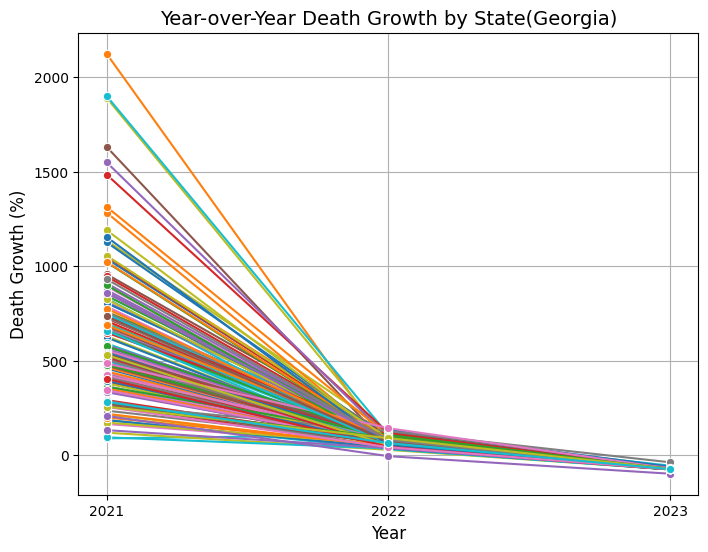

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))

# Cases Growth Visualization
sns.lineplot(
    data=state_data,
    x="year",
    y="death_growth",
    hue="county",
    marker="o",
    palette="tab10",
    legend=False,
    label="Cases Growth",
)
plt.title("Year-over-Year Death Growth by State(Georgia)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Death Growth (%)", fontsize=12)
plt.grid(True)
plt.show()


In [0]:
df_total_death = df.\
  groupBy(date_format("date","yyyy").alias("year"),"state").\
      agg(sum("cases").alias("total_cases"),sum("deaths").alias("total_deahts"))

window_spec = Window.partitionBy("year").orderBy(col("total_cases").desc())

df_total_death.\
  withColumn("ranks",f.row_number().over(window_spec)).\
    filter(col("ranks")<=5).\
      orderBy("year","ranks").\
        show()

+----+----------+-----------+------------+-----+
|year|     state|total_cases|total_deahts|ranks|
+----+----------+-----------+------------+-----+
|2020|California|  174969176|     3065113|    1|
|2020|     Texas|  160159130|     2927740|    2|
|2020|   Florida|  138123133|     2632238|    3|
|2020|  New York|  126307878|     8320598|    4|
|2020|  Illinois|   82118324|     2211390|    5|
|2021|California| 1496462536|    22532428|    1|
|2021|     Texas| 1195039278|    20088968|    2|
|2021|   Florida|  974170111|    15333245|    3|
|2021|  New York|  775764035|    18918470|    4|
|2021|  Illinois|  527956595|     9306526|    5|
|2022|California| 3657865258|    33481697|    1|
|2022|     Texas| 2606974755|    32175258|    2|
|2022|   Florida| 2342867989|    27708002|    3|
|2022|  New York| 2028292482|    25338652|    4|
|2022|  Illinois| 1242333880|    13938486|    5|
|2023|California|  985844951|     8424694|    1|
|2023|     Texas|  678812946|     7679552|    2|
|2023|   Florida|  6

In [0]:
bar_grp =df_total_death.\
  withColumn("ranks",f.row_number().over(window_spec)).\
    filter((col("year")==2021) & (col("ranks")<=5)).\
      orderBy("year","ranks")

In [0]:
bar_grp.show()

+----+----------+-----------+------------+-----+
|year|     state|total_cases|total_deahts|ranks|
+----+----------+-----------+------------+-----+
|2021|California| 1496462536|    22532428|    1|
|2021|     Texas| 1195039278|    20088968|    2|
|2021|   Florida|  974170111|    15333245|    3|
|2021|  New York|  775764035|    18918470|    4|
|2021|  Illinois|  527956595|     9306526|    5|
+----+----------+-----------+------------+-----+



In [0]:
import plotly.express as px

In [0]:
bar_pd = bar_grp.toPandas()

In [0]:
fig = px.bar(bar_pd, x="year", y=["total_cases"], color="state",text_auto=True)
fig.show()

In [0]:
bar_grp =df_total_death.\
  withColumn("ranks",f.row_number().over(window_spec)).\
    filter((col("ranks")<=5)).\
      orderBy("year","ranks")

In [0]:
pd_bar = bar_grp.toPandas()

In [0]:
fig = px.bar(pd_bar, x="year", y=["total_cases"],hover_data=['total_deahts'],labels={"value":"total_cases"},color="state",text_auto=True)
fig.show()

In [0]:
df_total_county = df.\
  groupBy(date_format("date","yyyy").alias("year"),"state","county").\
      agg(sum("cases").alias("total_cases"),sum("deaths").alias("total_deaths"))

window_spec = Window.partitionBy("year").orderBy(col("total_cases").desc())

df_total_county.\
  withColumn("ranks",f.row_number().over(window_spec)).\
    filter((col("state")=="California")).\
      orderBy("year","ranks").\
        show()

+----+----------+--------------+-----------+------------+-----+
|year|     state|        county|total_cases|total_deaths|ranks|
+----+----------+--------------+-----------+------------+-----+
|2020|California|   Los Angeles|   59976957|     1331978|    2|
|2020|California|     Riverside|   12947120|      233000|   10|
|2020|California|San Bernardino|   12451039|      171282|   13|
|2020|California|        Orange|   11731923|      225712|   14|
|2020|California|     San Diego|   10827207|      167372|   17|
|2020|California|          Kern|    6042885|       62450|   37|
|2020|California|        Fresno|    5401142|       66630|   52|
|2020|California|    Sacramento|    4674911|       77308|   61|
|2020|California|   Santa Clara|    4664377|       74379|   62|
|2020|California|       Alameda|    4319856|       75187|   68|
|2020|California|   San Joaquin|    3823964|       72833|   84|
|2020|California|  Contra Costa|    3292835|       40409|   98|
|2020|California|    Stanislaus|    3207

In [0]:
total_county_pd = df_total_county.toPandas()
total_county_2021 =  total_county_pd[total_county_pd['year']=='2021']

In [0]:
fig =px.pie(total_county_2021,values='total_cases',names='county',hover_data=['total_deaths'])
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=6, uniformtext_mode='hide')
fig.show()


In [0]:
years = total_county_pd['year'].unique() 
for year in years:
    # Filter the data for the specific year
    total_county_year = total_county_pd[total_county_pd['year'] == year]
    
    # Create a pie chart
    fig = px.pie(
        total_county_year,
        names='county',
        values='total_cases',
        hover_data=['total_deaths'],  
        title=f"COVID-19 Cases Distribution in California for {year}"
    )
    fig.update_traces(textposition='inside')
    fig.update_layout(uniformtext_minsize=6, uniformtext_mode='hide')
    fig.show()

In [0]:
windowspec = Window.partitionBy("state").orderBy("date").rowsBetween(-3,3)

ma_df = df.\
  withColumn("moving_avg_cases",f.avg('cases').over(windowspec))

In [0]:
ma_df.show(10)

+----------+---------+--------+----+-----+------+------------------+
|      date|   county|   state|fips|cases|deaths|  moving_avg_cases|
+----------+---------+--------+----+-----+------+------------------+
|2020-03-11|Jefferson|Arkansas|5069|    1|     0|               2.0|
|2020-03-12|Jefferson|Arkansas|5069|    1|     0|               2.8|
|2020-03-12|  Pulaski|Arkansas|5119|    5|     0|2.6666666666666665|
|2020-03-13|Jefferson|Arkansas|5069|    1|     0|3.2857142857142856|
|2020-03-13|  Pulaski|Arkansas|5119|    6|     0|3.4285714285714284|
|2020-03-14|Jefferson|Arkansas|5069|    2|     0|               4.0|
|2020-03-14|  Pulaski|Arkansas|5119|    7|     0| 4.428571428571429|
|2020-03-15|  Garland|Arkansas|5051|    2|     0| 4.428571428571429|
|2020-03-15|Jefferson|Arkansas|5069|    5|     0|3.7142857142857144|
|2020-03-15|  Pulaski|Arkansas|5119|    8|     0|3.5714285714285716|
+----------+---------+--------+----+-----+------+------------------+
only showing top 10 rows



In [0]:
import pandas as pd
ma_pd = ma_df.filter(col("state") == "California").toPandas()
ma_pd['date'] = pd.to_datetime(ma_pd['date'])

In [0]:
ma_pd.dtypes

date                datetime64[ns]
county                      object
state                       object
fips                       float64
cases                        int32
deaths                       int32
moving_avg_cases           float64
dtype: object

In [0]:
import plotly.graph_objects as go
import plotly.express as px

In [0]:
fig = px.line(ma_pd,x="date",y="moving_avg_cases",title='7 Day MA')
fig.show()

In [0]:
df_monthly = df.withColumn("year_month", date_format(col("date"), "yyyy-MM")) \
    .groupBy("year_month") \
    .agg(
        sum("cases").alias("total_cases"),
        sum("deaths").alias("total_deaths")
    ) \
    .orderBy("year_month")


In [0]:
df_monthly_pd = df_monthly.toPandas()

In [0]:
fig = px.line(df_monthly_pd, x='year_month', y='total_cases', title='Monthly COVID-19 Cases',
              labels={'year_month': 'Month', 'total_cases': 'Total Cases'})
fig.add_scatter(x=df_monthly_pd['year_month'], y=df_monthly_pd['total_deaths'], mode='lines', name='Total Deaths')

fig.update_layout(template='plotly_white', xaxis_tickangle=-45)
fig.show()